
# EEG Preprocessing — Single EDF (TUEP v2.0.1)

This notebook preprocesses **one** EDF file from the **TUH EEG Epilepsy Corpus (TUEP v2.0.1)** and saves clean epochs plus helpful plots for QA.

It follows the high-level steps inspired by:
- Typical clinical EEG preprocessing pipelines (10–20 montage, re-referencing, filtering, notch).
- Artifact reduction via ICA (only plotting)
- Fixed-length epoching and amplitude-based artifact rejection.
- Z-score normalization per recording.
- Saving arrays and metadata for downstream (e.g., graph-based SSL / GNN).

> Tip: Run cells top-to-bottom. Adjust the `CONFIG` section to point to your EDF and local output folders.


# Single-EDF EEG Preprocessing — Notebook Overview

This notebook performs **deterministic preprocessing** for a single TUH/TUEP EEG recording in EDF format and saves artifacts for downstream connectivity and graph-based learning.

## What this notebook does (short)
1. **Load** a raw EDF recording and **keep EEG channels only**.
2. **Standardize channel names**, apply a **10–20 montage** when available, and set **average reference**.
3. **Denoise**: apply a **notch filter at 60 Hz** (U.S. mains; optionally 120 Hz) and a **band-pass filter** (e.g., 0.5–40 Hz).
4. **Resample** to a target sampling rate (e.g., 200 Hz).
5. **Epoch** into fixed-length, non-overlapping windows (e.g., N seconds) and optionally **reject annotated bad segments**.
6. *(Optional)* **ICA**: fit and apply component exclusion for ocular/ECG artifacts with a fixed random seed.
7. **Save outputs**:
   - `*_X.npy` → array with shape **(n_epochs, n_channels, n_times)**.
   - `*_meta.json` → metadata (filters, notch, resample rate, epoch window, montage/reference, ICA flags, channel list, sampling frequency, input EDF path, library versions).
   - *(Optional)* `*_epochs.pkl` → MNE `Epochs` object for debugging/QC.
8. **Quick QC** plots (waveforms/PSDs) to verify filters, line-noise removal, and epoch quality.

## Inputs & outputs
- **Input**: path to one `.edf` file from TUEP/TUH.
- **Outputs**: saved under `data_pp/` by default (configurable).

## Parameters (defined in cells)
- `l_freq`, `h_freq` (band-pass), `notch_freqs` (60 Hz; optionally 120 Hz), `resample_sfreq`, `tmin`, `tmax`, `reject_by_annotation`, `do_ica`, `ica_n_components`, random seed.
- All parameters are recorded in `*_meta.json` for reproducibility.

## Notes for the thesis
- TUEP is U.S.-recorded data ⇒ **use 60 Hz notch** (consider 120 Hz if needed).
- Report the exact preprocessing settings (filters, resample rate, epoch length, reference, montage, ICA policy).

---
*Tip:* Keep this notebook for **QC & demonstration**; place the core functions in `src/preprocess_single.py` for clean reuse and batch processing.



## Requirements

- `mne`
- `numpy`
- `matplotlib`
- `scipy` (installed with `mne`)
- Optional: `autoreject` (not used here, but you can explore later)

```bash
pip install mne numpy matplotlib
```


In [2]:

# =========================
# CONFIG (EDIT THESE PATHS)
# =========================
import os

# Example Windows paths — change to your own
# EDF_PATH = r"C:\Users\georg\Desktop\DATA\01_no_epilepsy\aaaaafiy\s002_2010\01_tcp_ar\aaaaafiy_s002_t001.edf"
EDF_PATH = r"C:\Users\georg\Documents\GitHub\thesis-epilepsy-gnn\data_raw\DATA\00_epilepsy\aaaaaanr\s001_2003\02_tcp_le\aaaaaanr_s001_t001.edf"
# SAVE_DIR = r"C:\Users\georg\Desktop\Preprocessed"
SAVE_DIR = r"C:\Users\georg\Documents\GitHub\thesis-epilepsy-gnn\data_pp"
# PSD_DIR  = r"C:\Users\georg\Desktop\PSD_Plots"
PSD_DIR  = r"C:\Users\georg\Documents\GitHub\thesis-epilepsy-gnn\figures\psd"

os.makedirs(SAVE_DIR, exist_ok=True)
os.makedirs(PSD_DIR, exist_ok=True)

# Core 10–20 + T1/T2 list we try to keep consistently across files
CORE_CHS = [
    'Fp1','Fp2','F7','F3','Fz','F4','F8',
    'T1','T3','C3','Cz','C4','T4','T2',
    'T5','P3','Pz','P4','T6','O1','Oz','O2'
]

# Processing hyperparams
FS_TARGET = 250         # resample frequency (Hz)
HP, LP = 0.5, 100.0     # bandpass
NOTCH = 60              # mains frequency
EPOCH_DUR = 2.0         # seconds
REJECT_PERCENTILE = 95  # amplitude-based epoch rejection
SEED = 42               # reproducibility for ICA


In [3]:

# ==============
# IMPORTS
# ==============
import re
import mne
import numpy as np
import pickle
import matplotlib.pyplot as plt
from mne.preprocessing import ICA
mne.set_log_level("ERROR")
print(mne.__version__)


1.10.1



## 1) Load EDF and keep EEG

We also **clean channel names** to strip common suffixes (`EEG `, `-LE`, `-REF`), then keep only a consistent subset (`CORE_CHS`) if present.


In [4]:

raw_before = mne.io.read_raw_edf(EDF_PATH, preload=True, verbose='ERROR')
raw_before.pick_types(eeg=True)
print("Original channel names:", raw_before.ch_names)

# Clean channel names
mapping = {
    orig: re.sub(r'^(?:EEG\s*)', '', orig).replace('-LE','').replace('-REF','').strip()
    for orig in raw_before.ch_names
}
raw_before.rename_channels(mapping)
print("Cleaned names:", raw_before.ch_names)

# Work on a copy
raw = raw_before.copy()

# Keep only the core channels that exist in this file
present = [ch for ch in CORE_CHS if ch in raw.ch_names]
raw.pick_channels(present)
raw_before.pick_channels(present)
print(f"Picked {len(present)}/{len(CORE_CHS)} channels")
print("Picked channels:", present)



Original channel names: ['EEG FP1-LE', 'EEG FP2-LE', 'EEG F3-LE', 'EEG F4-LE', 'EEG C3-LE', 'EEG C4-LE', 'EEG A1-LE', 'EEG A2-LE', 'EEG P3-LE', 'EEG P4-LE', 'EEG O1-LE', 'EEG O2-LE', 'EEG F7-LE', 'EEG F8-LE', 'EEG T3-LE', 'EEG T4-LE', 'EEG T5-LE', 'EEG T6-LE', 'EEG FZ-LE', 'EEG CZ-LE', 'EEG PZ-LE', 'EEG OZ-LE', 'EEG PG1-LE', 'EEG PG2-LE', 'EEG EKG-LE', 'EEG SP2-LE', 'EEG SP1-LE', 'EEG 28-LE', 'EEG 29-LE', 'EEG 30-LE', 'EEG T1-LE', 'EEG T2-LE', 'PHOTIC PH']
Cleaned names: ['FP1', 'FP2', 'F3', 'F4', 'C3', 'C4', 'A1', 'A2', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'FZ', 'CZ', 'PZ', 'OZ', 'PG1', 'PG2', 'EKG', 'SP2', 'SP1', '28', '29', '30', 'T1', 'T2', 'PHOTIC PH']
Picked 16/22 channels
Picked channels: ['F7', 'F3', 'F4', 'F8', 'T1', 'T3', 'C3', 'C4', 'T4', 'T2', 'T5', 'P3', 'P4', 'T6', 'O1', 'O2']



## 2) Apply 10–20 montage (+ approximate T1/T2)

We attach a standard montage for spatial consistency. T1/T2 positions are approximate and only used if present.


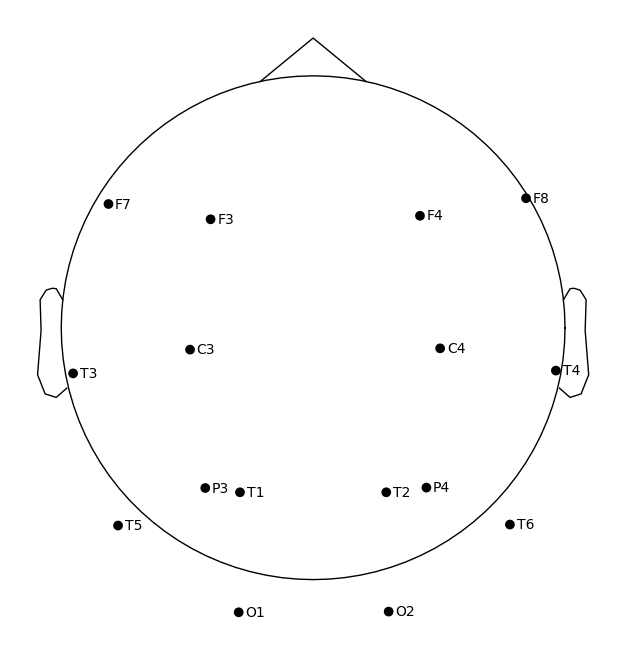

In [5]:
# NOTE: T1/T2 use approximate coords (placeholders) for plotting/adjacency only.
# For geometry-sensitive work, rename to FT9/FT10 or TP9/TP10 and use standard_1020 positions.

std_montage = mne.channels.make_standard_montage('standard_1020')
pos = std_montage.get_positions()['ch_pos']

# Approximate locations for T1/T2
extra_pos = {
    'T1': np.array([-0.040, -0.090, 0.120]),
    'T2': np.array([ 0.040, -0.090, 0.120]),
}

all_pos = dict(pos)
all_pos.update(extra_pos)

custom_montage = mne.channels.make_dig_montage(ch_pos=all_pos, coord_frame='head')
raw.set_montage(custom_montage, match_case=False)
# Quick sanity check (optional)
# raw.plot_sensors(kind='topomap');  # should show your electrodes placed
raw.plot_sensors(kind='topomap', show_names=True);




## 3) Re-reference, Notch, and Bandpass Filter


In [6]:

raw.set_eeg_reference('average', projection=False)
raw.notch_filter(freqs=NOTCH)
raw.filter(l_freq=HP, h_freq=LP, fir_design='firwin', filter_length='auto')


<RawEDF | aaaaaanr_s001_t001.edf, 16 x 303500 (1214.0 s), ~37.1 MiB, data loaded>


## 4) ICA for Artifact Reduction

We compute ICA (FastICA) and **apply it without manual selection** for a reproducible demo.  
For a production pipeline, you may want to visually inspect components or use EOG/ECG templates.


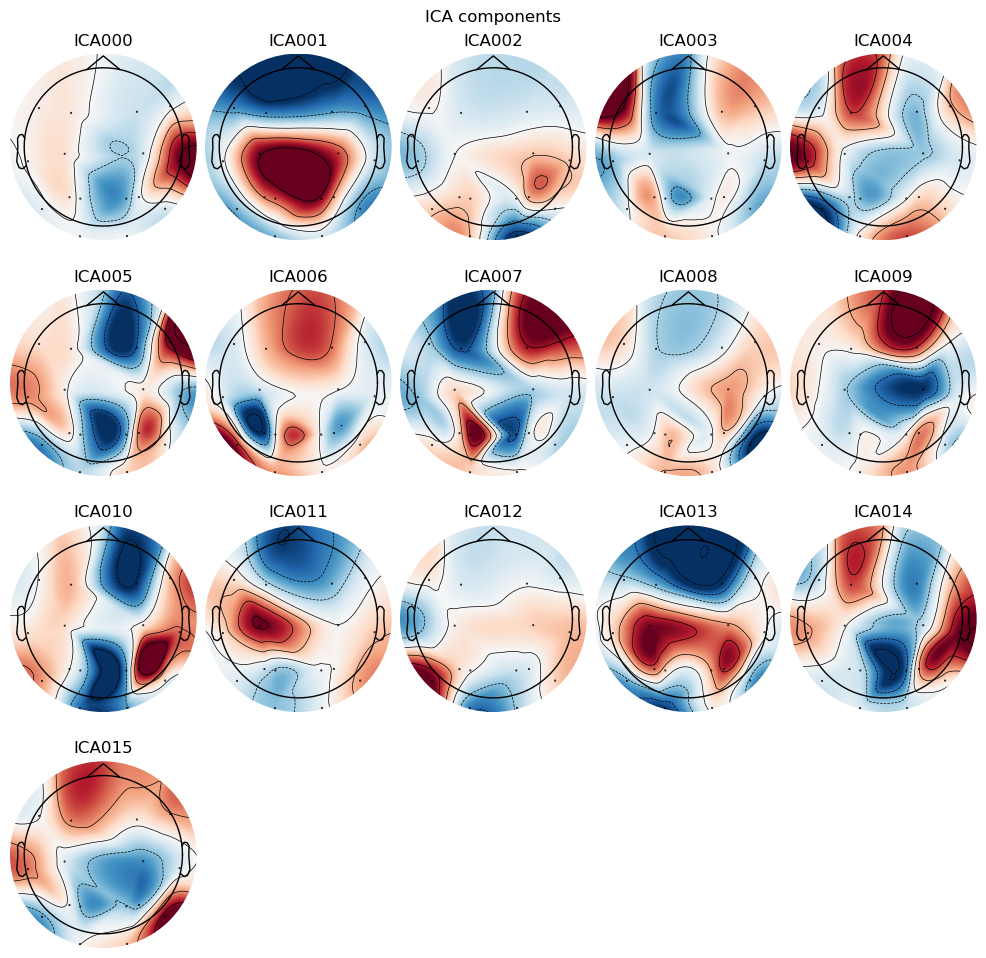

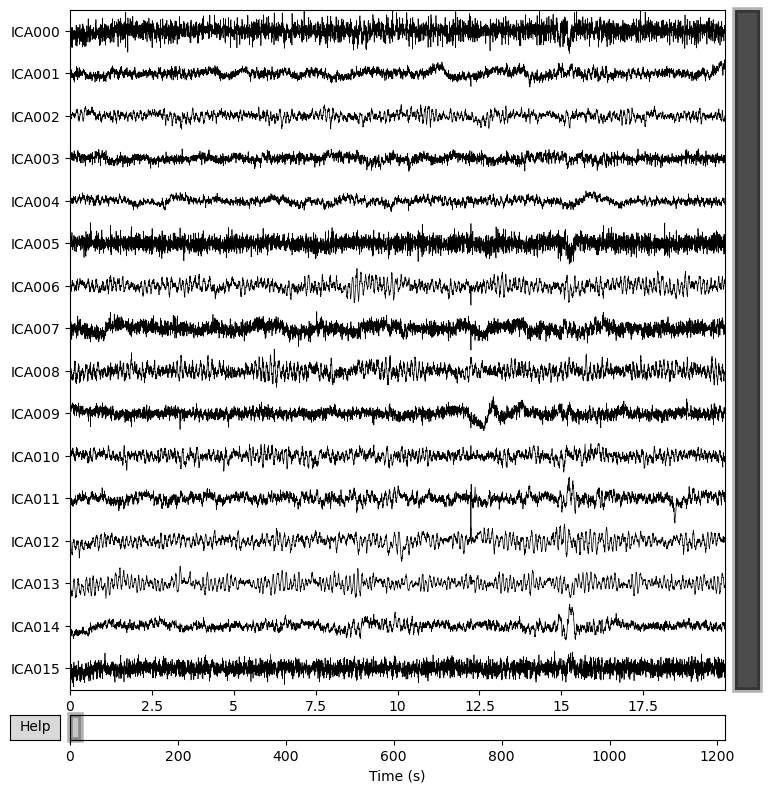

In [7]:

n_components = min(20, len(raw.ch_names))
ica = ICA(n_components=n_components, method='fastica', random_state=SEED)
ica.fit(raw)


# ---- Plot spatial maps (topographies) of all ICs ----
ica.plot_components(inst=raw)  
# Each subplot = an independent component (IC).
# Blinks typically look like big frontal weights, heartbeat has strong vertical dipole.

# ---- Plot time series of ICs ----
ica.plot_sources(raw);
# Scroll through the signals; blink ICs show big sharp deflections.

# In an interactive session, consider: ica.plot_components(); ica.plot_sources(raw)
#ica.apply(raw)
#print("ICA applied.")





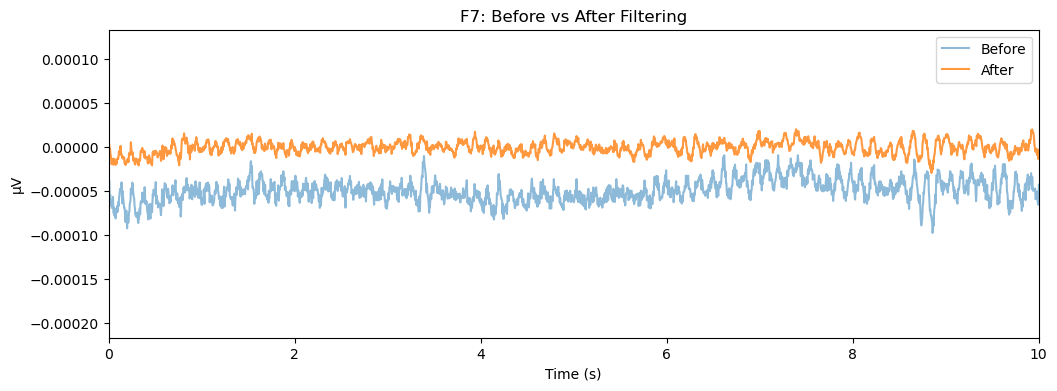

In [8]:
# 5) Time-series before/after filtering (first channel, 10 s)
ch0 = raw.ch_names[0]
data_b = raw_before.get_data(picks=[ch0])[0]
data_a = raw.get_data(picks=[ch0])[0]
t_b = np.arange(len(data_b)) / raw_before.info['sfreq']
t_a = np.arange(len(data_a)) / raw.info['sfreq']
plt.figure(figsize=(12,4))
plt.plot(t_b, data_b, alpha=0.5, label='Before')
plt.plot(t_a, data_a, alpha=0.8, label='After')
plt.xlim(0,10)
plt.xlabel("Time (s)"); plt.ylabel("µV")
plt.title(f"{ch0}: Before vs After Filtering")
plt.legend()
plt.show()


## 5) PSD Before/After

We visualize and save PSD plots to quickly verify filtering efficacy.


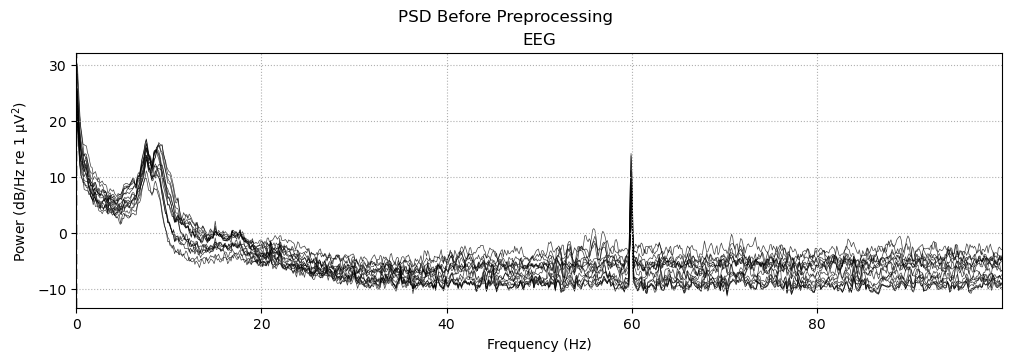

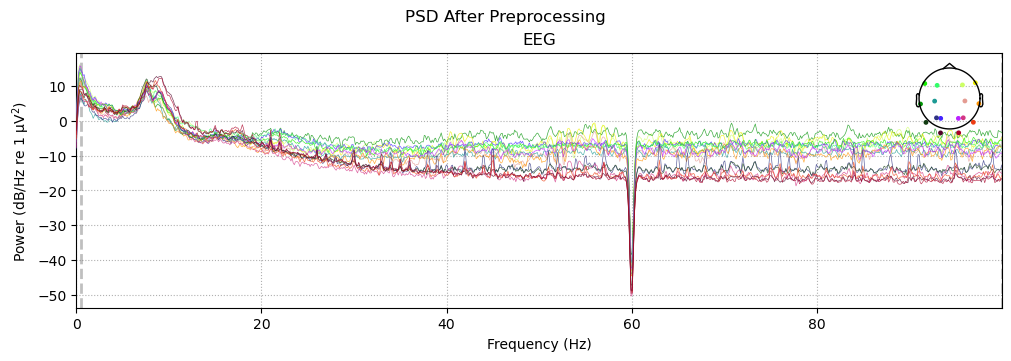

Saved: C:\Users\georg\Documents\GitHub\thesis-epilepsy-gnn\figures\psd\aaaaaanr_s001_t001_PSD_before.png
Saved: C:\Users\georg\Documents\GitHub\thesis-epilepsy-gnn\figures\psd\aaaaaanr_s001_t001_PSD_after.png


In [9]:

psd_b = raw_before.compute_psd(fmax=LP, average='mean')
fig_b = psd_b.plot(show=False)
fig_b.suptitle("PSD Before Preprocessing")
plt.show()
patient_id = os.path.splitext(os.path.basename(EDF_PATH))[0]
out_b = os.path.join(PSD_DIR, f"{patient_id}_PSD_before.png")
fig_b.savefig(out_b); plt.close(fig_b)

psd_a = raw.compute_psd(fmax=LP, average='mean')
fig_a = psd_a.plot(show=False)
fig_a.suptitle("PSD After Preprocessing")
plt.show()
out_a = os.path.join(PSD_DIR, f"{patient_id}_PSD_after.png")
fig_a.savefig(out_a); plt.close(fig_a)

print("Saved:", out_b)
print("Saved:", out_a)



## 6) Resample (and optional initial crop)

We resample to **250 Hz** for modeling convenience.  
If the file is **non-epileptic** (path contains `01_no_epilepsy`), we crop the initial 10s (often setup noise).


In [10]:

raw.resample(FS_TARGET)
print("Resampled to", raw.info['sfreq'], "Hz")

if "01_no_epilepsy" in EDF_PATH.replace("/", "\\"):
    print("Cropping out first 10 s (non-epilepsy file)")
    raw.crop(tmin=10.0)


Resampled to 250.0 Hz



## 7) Fixed-Length Epochs


In [11]:

epochs = mne.make_fixed_length_epochs(raw, duration=EPOCH_DUR, overlap=0.0, preload=True)
print(epochs)


<Epochs | 607 events (all good), 0 – 1.996 s (baseline off), ~37.1 MiB, data loaded,
 '1': 607>



## 8) Amplitude-Based Artifact Rejection (Percentile)

We reject epochs whose **peak-to-peak amplitude** exceeds the **95th percentile** of this recording’s distribution.


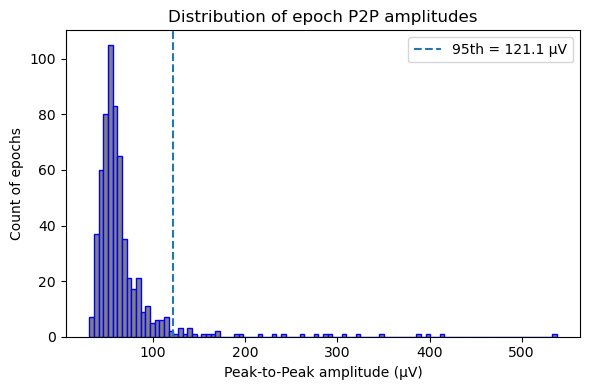

576 / 607 epochs kept


In [12]:

data = epochs.get_data()                           # (n_epochs, n_channels, n_times)
ptps = np.ptp(data, axis=2)                        # per-epoch per-channel
max_ptp = ptps.max(axis=1) * 1e6                   # μV

import matplotlib.pyplot as plt
plt.figure(figsize=(6,4))
plt.hist(max_ptp, bins=100, color='gray', edgecolor='blue')
plt.xlabel("Peak-to-Peak amplitude (µV)")
plt.ylabel("Count of epochs")
plt.title("Distribution of epoch P2P amplitudes")
threshold = np.percentile(max_ptp, REJECT_PERCENTILE)
plt.axvline(threshold, linestyle='--', label=f"{REJECT_PERCENTILE}th = {threshold:.1f} µV")
plt.legend(); plt.tight_layout()
plt.show()

reject_criteria = dict(eeg=threshold * 1e-6)
epochs_clean = epochs.copy().drop_bad(reject=reject_criteria)
print(f"{len(epochs_clean)} / {len(epochs)} epochs kept")



## 9) Z-Score Normalization (per recording)


In [13]:
#not sure

#data_clean = epochs_clean.get_data()
#mean_val, std_val = data_clean.mean(), data_clean.std()
#epochs_clean._data = (data_clean - mean_val) / (std_val + 1e-8)
#print("Z-scoring done.")


# Per-channel, per-epoch z-scoring (recommended)
data_clean = epochs_clean.get_data()              # shape: (E, C, T)
mu = data_clean.mean(axis=2, keepdims=True)       # (E, C, 1)
sd = data_clean.std(axis=2, keepdims=True)        # (E, C, 1)
sd[sd == 0] = 1.0                                  # avoid divide-by-zero
epochs_clean._data = (data_clean - mu) / (sd + 1e-8)
print("Z-scoring done (per-channel, per-epoch).")


Z-scoring done (per-channel, per-epoch).



## 10) Quick Visual Checks

- Ten random epochs, stacked.
- All channels concatenated across first N epochs.


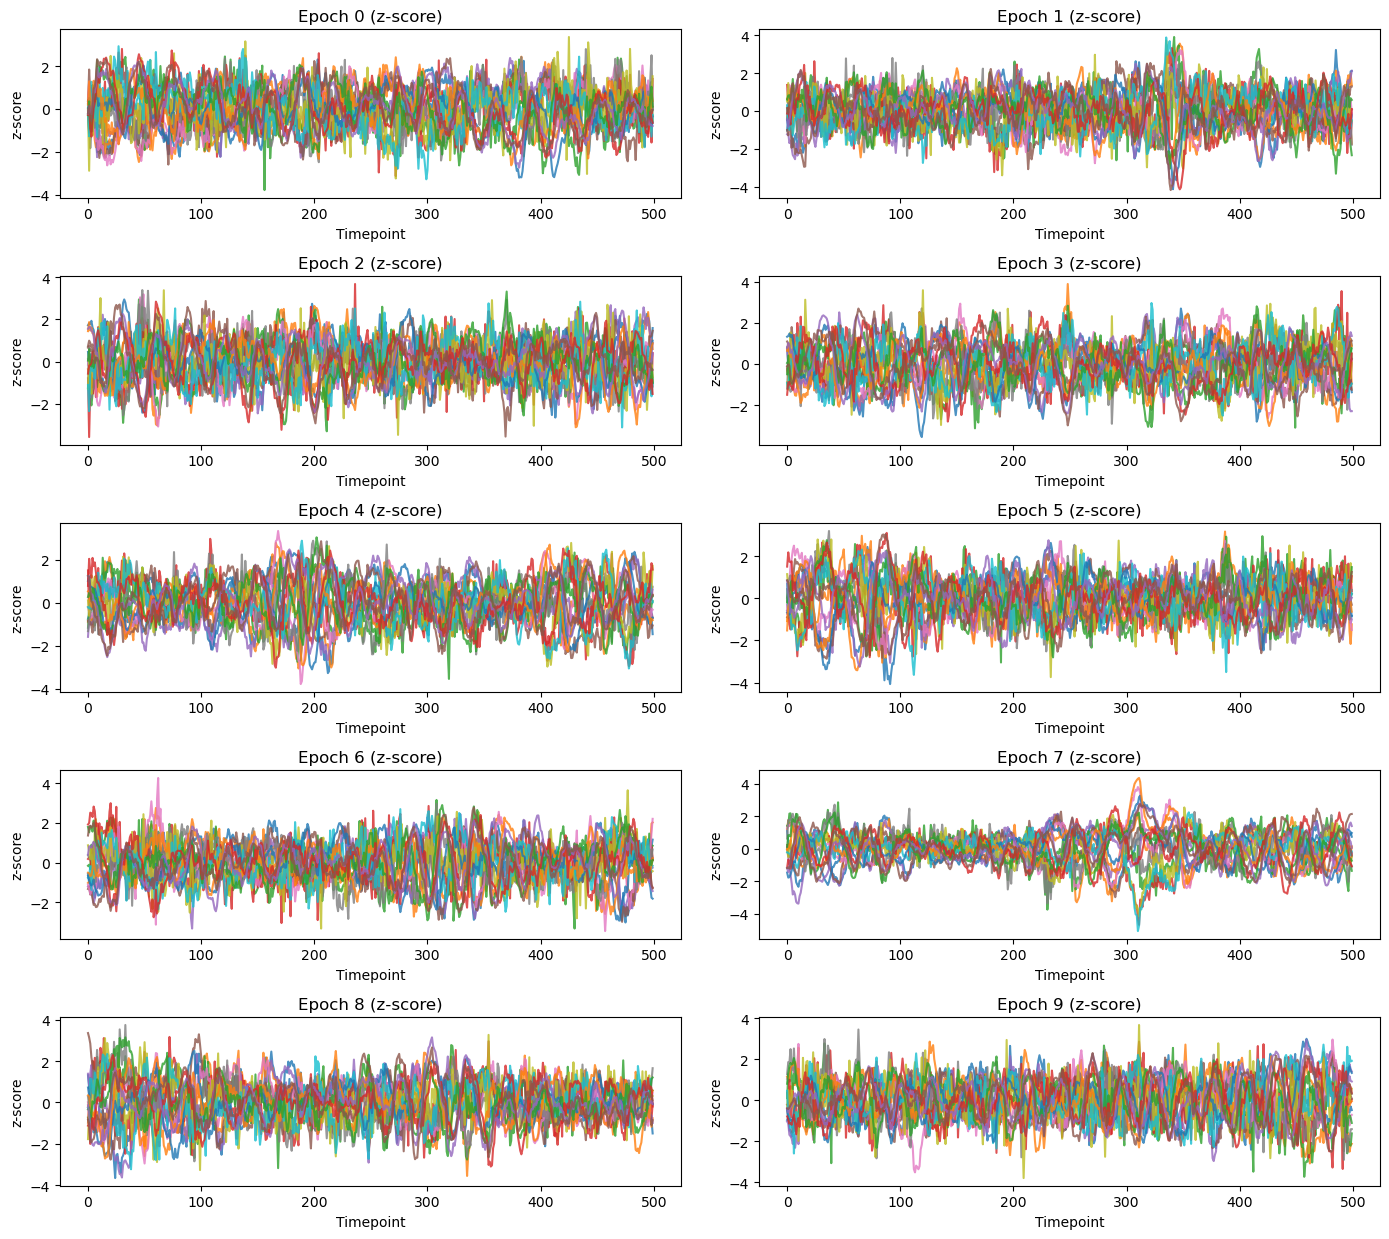

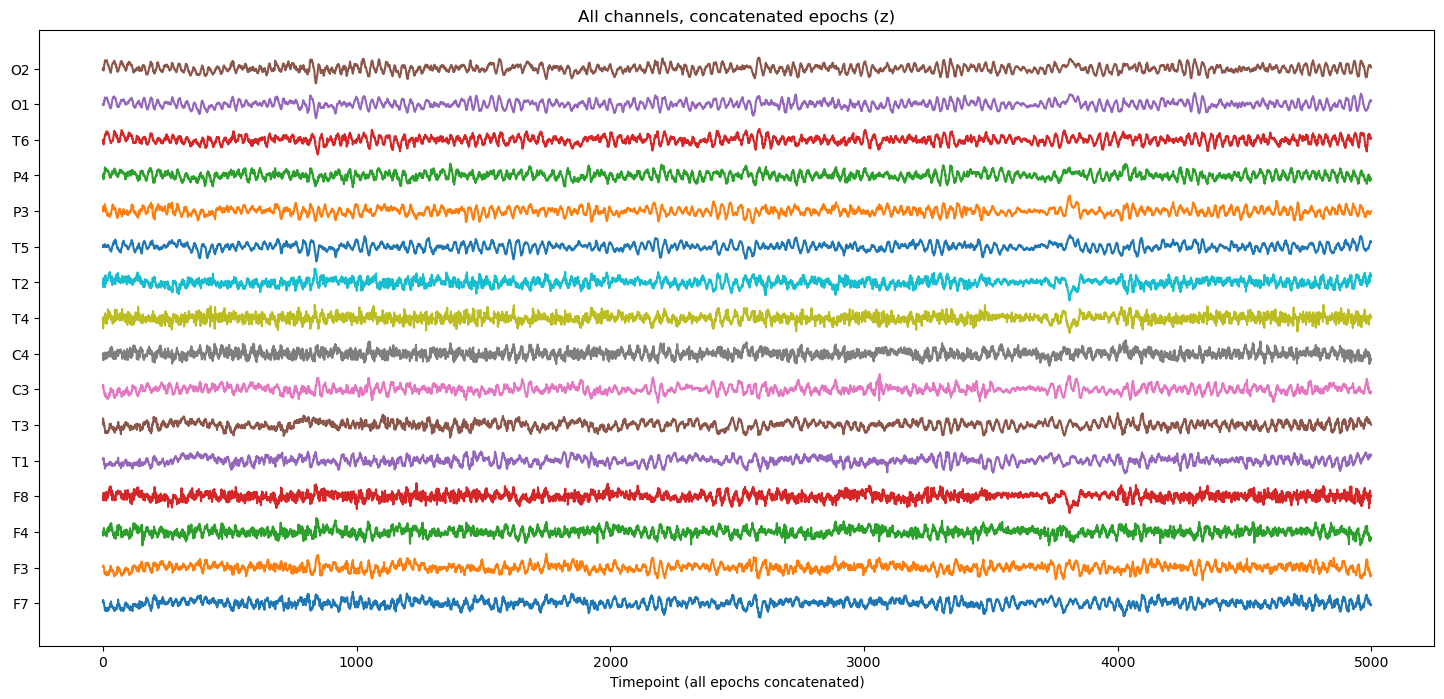

In [14]:

import numpy as np
n_epochs_to_plot = min(10, len(epochs_clean))
idxs = np.arange(n_epochs_to_plot)

ch_names = epochs_clean.ch_names
data = epochs_clean.get_data()

plt.figure(figsize=(14, 2.5 * ((n_epochs_to_plot+1)//2)))
n_cols = 2
n_rows = (n_epochs_to_plot + n_cols - 1) // n_cols
for i in range(n_epochs_to_plot):
    plt.subplot(n_rows, n_cols, i + 1)
    for ch_idx, ch_name in enumerate(ch_names):
        plt.plot(data[i, ch_idx], alpha=0.8)
    plt.title(f"Epoch {i} (z-score)")
    plt.xlabel("Timepoint"); plt.ylabel("z-score")
plt.tight_layout(); plt.show()

# Concatenate first N epochs for each channel
n_concat = min(10, len(epochs_clean))
concat = np.hstack([data[i] for i in range(n_concat)])  # (channels, n_concat * n_times)
plt.figure(figsize=(18, 8))
offset = 10
for ch in range(len(ch_names)):
    plt.plot(concat[ch] + ch * offset)
plt.yticks([ch * offset for ch in range(len(ch_names))], ch_names)
plt.xlabel("Timepoint (all epochs concatenated)"); plt.title("All channels, concatenated epochs (z)")
plt.show()



## 11) Save Arrays & Metadata


In [15]:

patient_id = os.path.splitext(os.path.basename(EDF_PATH))[0]
label = 1 if "00_epilepsy" in EDF_PATH.replace("/", "\\") else 0
labels = np.full(len(epochs_clean), label, dtype=int)

prefix = os.path.join(SAVE_DIR, patient_id)
np.save(f"{prefix}_raw.npy", raw.get_data())
np.save(f"{prefix}_epochs.npy", epochs_clean.get_data())
np.save(f"{prefix}_labels.npy", labels)
with open(f"{prefix}_info.pkl", "wb") as f:
    pickle.dump(raw.info, f)

print("Saved:")
print(f"  {prefix}_raw.npy")
print(f"  {prefix}_epochs.npy")
print(f"  {prefix}_labels.npy")
print(f"  {prefix}_info.pkl")


Saved:
  C:\Users\georg\Documents\GitHub\thesis-epilepsy-gnn\data_pp\aaaaaanr_s001_t001_raw.npy
  C:\Users\georg\Documents\GitHub\thesis-epilepsy-gnn\data_pp\aaaaaanr_s001_t001_epochs.npy
  C:\Users\georg\Documents\GitHub\thesis-epilepsy-gnn\data_pp\aaaaaanr_s001_t001_labels.npy
  C:\Users\georg\Documents\GitHub\thesis-epilepsy-gnn\data_pp\aaaaaanr_s001_t001_info.pkl


In [16]:
import numpy as np
X = np.load(f"{prefix}_epochs.npy"); y = np.load(f"{prefix}_labels.npy")
assert X.ndim == 3 and X.shape[0] == len(y) and np.isfinite(X).all()
print("Notebook output OK:", X.shape)


Notebook output OK: (576, 16, 500)


In [17]:
print("sfreq:", raw.info["sfreq"])  # after resample
print("epoch_len_est_s:", X.shape[2] / raw.info["sfreq"])
print("total_recording_min (approx):", X.shape[0] * (X.shape[2] / raw.info["sfreq"]) / 60)
print("n_channels:", X.shape[1])


sfreq: 250.0
epoch_len_est_s: 2.0
total_recording_min (approx): 19.2
n_channels: 16
